# NBA MVP Prediction Using Machine Learning
This notebook follows the same structure as `mvp_prediction.py`, loading data, preprocessing, training three models (Logistic Regression, Random Forest, XGBoost), evaluating them, plotting ROC curves, and running SHAP interpretability.

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
    roc_curve
)

# Load data
mvp = pd.read_csv("data/mvp_history.csv", skiprows=1, usecols=["Season", "Player"])
mvp["season"] = mvp["Season"].str.split("-", expand=True)[0].astype(int) + 1
mvp = mvp.rename(columns={"Player": "player"})[["season", "player"]].assign(MVP=1)

bb = pd.read_csv("data/NBA_Dataset.csv")
rap_h = pd.read_csv("data/historical_RAPTOR_by_player.csv")
rap_m = pd.read_csv("data/modern_RAPTOR_by_player.csv")
rap_cols = ["player_name", "season", "raptor_offense", "raptor_defense", "raptor_total"]
rap = pd.concat([rap_h[rap_cols], rap_m[rap_cols]], ignore_index=True)
rap = rap.drop_duplicates(subset=["player_name", "season"]).rename(columns={"player_name": "player"})

df = bb.merge(rap, on=["season", "player"], how="left").merge(mvp, on=["season", "player"], how="left")
df["MVP"] = df["MVP"].fillna(0).astype(int)
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())


In [126]:
# Feature engineering
features = [
    'ws', 'bpm', 'vorp', 'win_loss_pct',
    'pts_per_g', 'trb_per_g', 'ast_per_g',
    'raptor_offense', 'raptor_defense', 'raptor_total'
]
X = df[features]
y = df["MVP"]


In [127]:
# Train/test split
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# Train models
models = {
    "LogisticRegression": Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(max_iter=2000, random_state=42))
    ]).fit(X_tr, y_tr),
    "RandomForest": RandomForestClassifier(
        n_estimators=300, max_depth=8, random_state=42, n_jobs=1
    ).fit(X_tr, y_tr),
    "XGBoost": xgb.XGBClassifier(
        n_estimators=300, learning_rate=0.05,
        use_label_encoder=False, eval_metric="logloss",
        random_state=42, n_jobs=1
    ).fit(X_tr, y_tr)
}


/Users/slcfs/Documents/mvpprediction/myenv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:46:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [128]:
# Evaluation & Reporting
for name, model in models.items():
    y_pred = model.predict(X_te)
    y_prob = model.predict_proba(X_te)[:, 1]
    print(f"=== {name} ===")
    print(classification_report(y_te, y_pred, digits=3))
    print(f"ROC AUC: {roc_auc_score(y_te, y_prob):.3f}")
    tn, fp, fn, tp = confusion_matrix(y_te, y_pred).ravel()
    print(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}\n")


=== LogisticRegression ===
              precision    recall  f1-score   support

           0      0.999     1.000     1.000      3532
           1      0.857     0.750     0.800         8

    accuracy                          0.999      3540
   macro avg      0.928     0.875     0.900      3540
weighted avg      0.999     0.999     0.999      3540

ROC AUC: 0.999
Confusion Matrix: TN=3531, FP=1, FN=2, TP=6

=== RandomForest ===
              precision    recall  f1-score   support

           0      0.999     1.000     0.999      3532
           1      0.800     0.500     0.615         8

    accuracy                          0.999      3540
   macro avg      0.899     0.750     0.807      3540
weighted avg      0.998     0.999     0.998      3540

ROC AUC: 0.998
Confusion Matrix: TN=3531, FP=1, FN=4, TP=4

=== XGBoost ===
              precision    recall  f1-score   support

           0      0.999     0.999     0.999      3532
           1      0.571     0.500     0.533         8

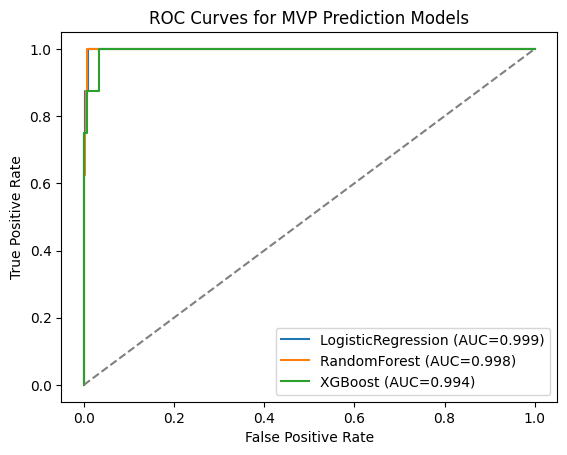

In [129]:
# Plot ROC curves
plt.figure()
for name, model in models.items():
    probas = model.predict_proba(X_te)[:, 1]
    fpr, tpr, _ = roc_curve(y_te, probas)
    auc = roc_auc_score(y_te, probas)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for MVP Prediction Models")
plt.legend()
plt.show()


Skipping LogisticRegression (no native feature importance)


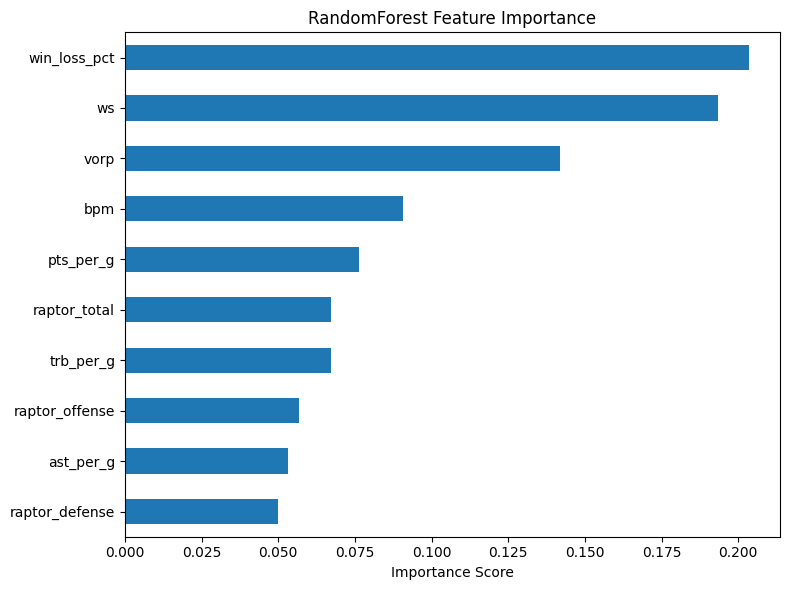

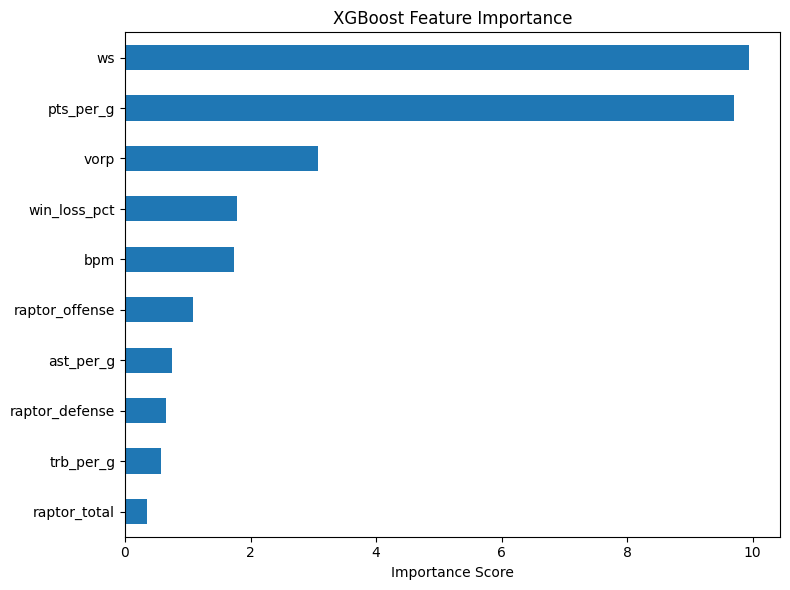

In [130]:
for name, model in models.items():
    if name == "XGBoost":
        booster = model.get_booster()
        score = booster.get_score(importance_type="gain")
        importances = pd.Series(score).reindex(features).fillna(0)
    elif hasattr(model, "feature_importances_"):
        importances = pd.Series(model.feature_importances_, index=features)
    else:
        print(f"Skipping {name} (no native feature importance)")
        continue

    importances = importances.sort_values(ascending=False)
    plt.figure(figsize=(8, 6))
    importances.plot(kind="barh")
    plt.title(f"{name} Feature Importance")
    plt.xlabel("Importance Score")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

ExactExplainer explainer: 14158it [01:23, 146.87it/s]                           


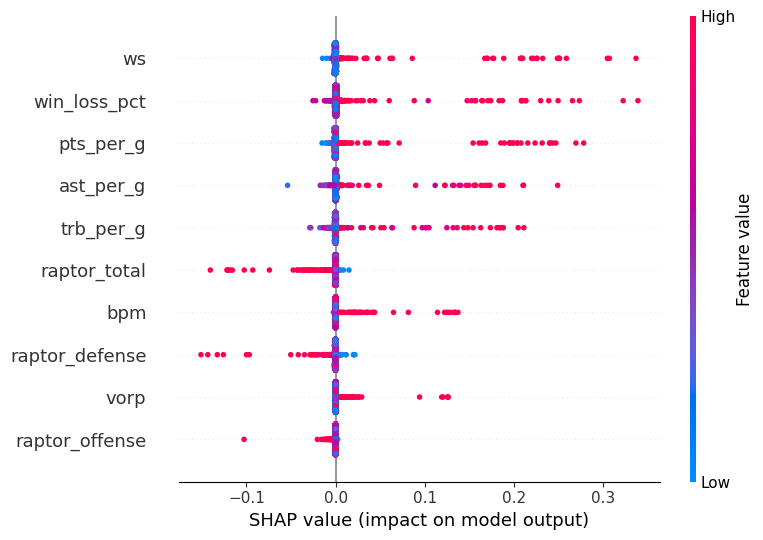

In [131]:
# SHAP interpretability for Logistic Regression
scaler = models["LogisticRegression"].named_steps["scaler"]
estimator = models["LogisticRegression"].named_steps["lr"]
X_scaled = scaler.transform(X_tr)

explainer = shap.Explainer(estimator.predict, masker=shap.maskers.Independent(X_scaled))
shap_vals = explainer(X_scaled)
shap.summary_plot(shap_vals, X_scaled, feature_names=features)
